# Разработка предсказательной модели температуры расплавленного состояния сплава

## Описание процесса:

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Цель проекта:

Разработать модель, которая предскажет температуру стали в конце процесса на этапе обработки стали с изначально заданными параметрами для оптимизации потребления электроэнергии.

## Исходные даные:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## Задачи:

1. Изучить корректность и достаточность данных ( найти все аномалии и закономерности на основе которых стоит проводить предобработку данных);
2. Провести предобработку данных(подготовка признаков, удаление выбросов и аномалий в данных, определение целевого признака и признаков для обчения модели);
3. Обучение моделей;
4. Оценка эфективности моделей на тестовых данных и выбор оптимальной.

подключение бибилотек

In [ ]:
pip install catboost

In [ ]:
pip install sklearn

In [1]:
import warnings

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from catboost import Pool

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import IsolationForest

чтение датасетов

In [3]:
try:
    data_arc = pd.read_csv(r'C:\Users\Maksim.Bakulin\DS final project(datasets)\data_arc.csv') 
    data_bulk = pd.read_csv(r'C:\Users\Maksim.Bakulin\DS final project(datasets)\data_bulk.csv') 
    data_bulk_time = pd.read_csv(r'C:\Users\Maksim.Bakulin\DS final project(datasets)\data_bulk_time.csv') 
    data_gas = pd.read_csv(r'C:\Users\Maksim.Bakulin\DS final project(datasets)\data_gas.csv') 
    data_temp = pd.read_csv(r'C:\Users\Maksim.Bakulin\DS final project(datasets)\data_temp.csv') 
    data_wire = pd.read_csv(r'C:\Users\Maksim.Bakulin\DS final project(datasets)\data_wire.csv')
    data_wire_time = pd.read_csv(r'C:\Users\Maksim.Bakulin\DS final project(datasets)\data_wire_time.csv') 
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv') 
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv') 
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv') 
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv') 
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv') 
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv') 

### 1. Первичный анализ данных

#### 1.1 Данные об электродах

In [4]:
data_arc.head()

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397

In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
data_arc.describe()

key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             0.637371
max     3241.000000           3.731596             2.676388

In [7]:
data_arc[data_arc['Реактивная мощность'] > 0].describe()

key  Активная мощность  Реактивная мощность
count  14875.000000       14875.000000         14875.000000
mean    1615.186756           0.670453             0.500723
std      934.593897           0.408170             0.310880
min        1.000000           0.030002             0.020806
25%      806.000000           0.395295             0.291003
50%     1617.000000           0.555565             0.415984
75%     2429.000000           0.857049             0.637403
max     3241.000000           3.731596             2.676388

In [8]:
data_arc[data_arc['Реактивная мощность'] > 0].corr()

key  Активная мощность  Реактивная мощность
key                  1.000000          -0.021367            -0.000159
Активная мощность   -0.021367           1.000000             0.963182
Реактивная мощность -0.000159           0.963182             1.000000

In [9]:
len(data_arc['key'].unique())

3214

<AxesSubplot:>

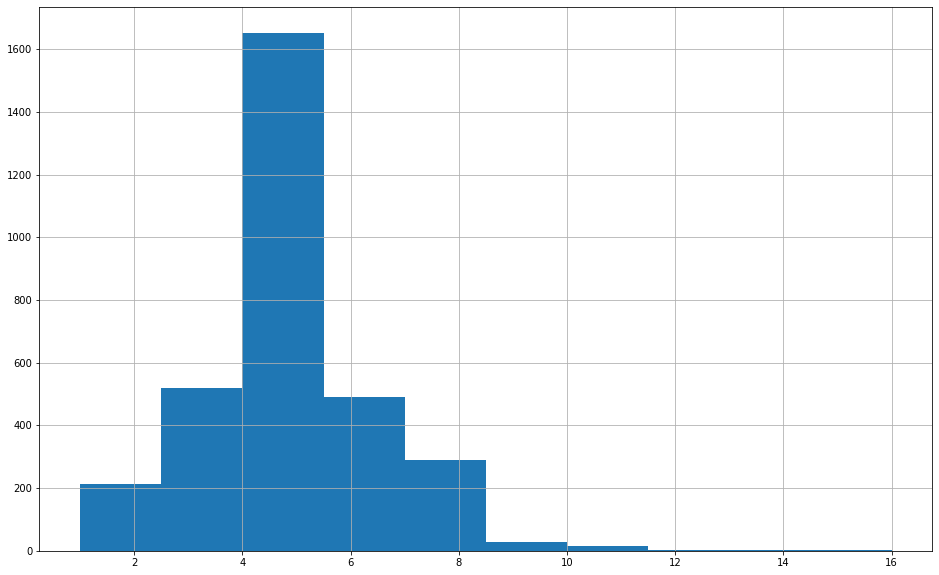

In [10]:
data_arc['key'].value_counts().hist(figsize=(16,10))

In [11]:
def histogram_boxplot(data, xlabel = None, title = None, font_scale=2, figsize=(16,10), bins = None):
    sns.set(font_scale=font_scale)
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.10, .95)}, figsize=figsize)
    sns.boxplot(data, ax=ax_box2)
    sns.distplot(data, ax=ax_hist2, bins=bins) if bins else sns.distplot(data, ax=ax_hist2)
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title)
    plt.show()



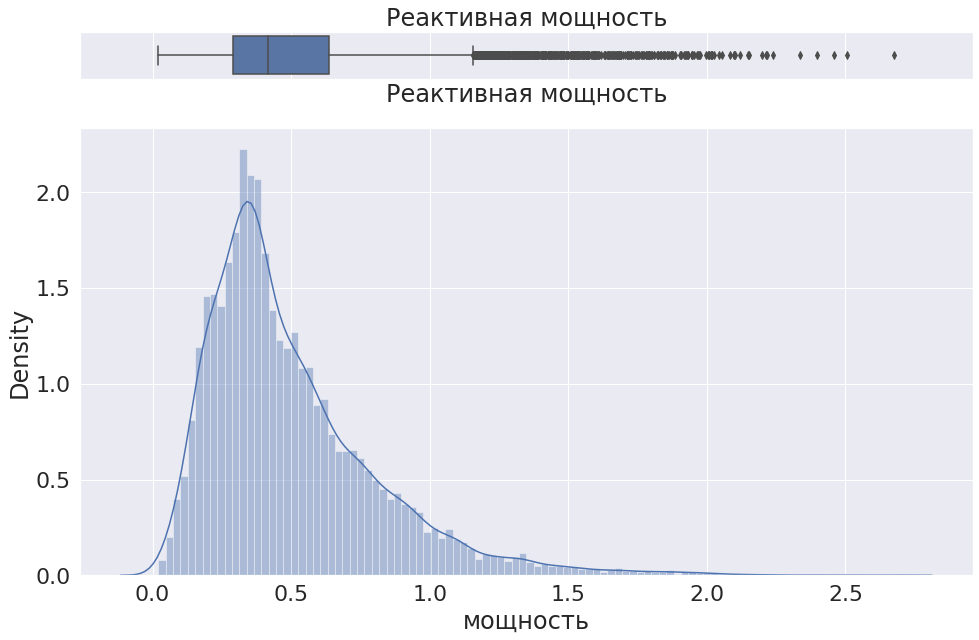

In [12]:
histogram_boxplot(data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'], bins = 100, title="Реактивная мощность", xlabel="мощность")

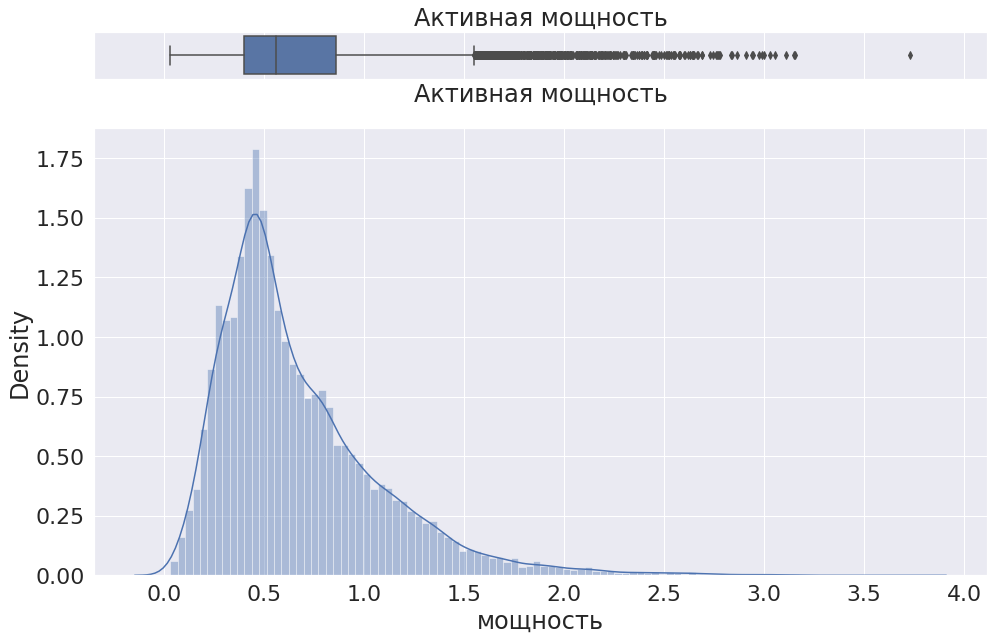

In [13]:
histogram_boxplot(data_arc[data_arc['Реактивная мощность'] > 0]['Активная мощность'], bins = 100, title="Активная мощность", xlabel="мощность")

#### 1.2 Данные о подаче сыпучих материалов (объём)

In [14]:
data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [15]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
len(data_bulk['key'].unique())

3129

In [17]:
fig = go.Figure()
for column in data_bulk.columns:
    if column[0] == 'B':  
        fig.add_trace(go.Histogram(x=data_bulk[column],name=column))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [18]:
data_bulk.describe()

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

In [19]:
data_bulk.corr()

key    Bulk 1    Bulk 2    Bulk 3    Bulk 4    Bulk 5    Bulk 6  \
key      1.000000 -0.192066 -0.038643 -0.080335 -0.101955 -0.018074 -0.063539   
Bulk 1  -0.192066  1.000000 -0.073762  0.016731 -0.040465 -0.368980  0.141745   
Bulk 2  -0.038643 -0.073762  1.000000       NaN  0.393882  0.070350       NaN   
Bulk 3  -0.080335  0.016731       NaN  1.000000 -0.260918  0.144410  0.253080   
Bulk 4  -0.101955 -0.040465  0.393882 -0.260918  1.000000 -0.077214 -0.333841   
Bulk 5  -0.018074 -0.368980  0.070350  0.144410 -0.077214  1.000000 -0.511112   
Bulk 6  -0.063539  0.141745       NaN  0.253080 -0.333841 -0.511112  1.000000   
Bulk 7  -0.049425 -0.086223 -0.010043       NaN  0.324940  0.304476       NaN   
Bulk 8        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
Bulk 9   0.262741       NaN       NaN  0.072850  0.766565       NaN       NaN   
Bulk 10  0.288135 -0.278055       NaN -0.244532 -0.516399       NaN       NaN   
Bulk 11 -0.156748  0.461895       NaN  0.137997       NaN       NaN -0.104251   
Bulk 12 -0.030981  0.370501       NaN  0.011648  0.051112  0.007650 -0.079822   
Bulk 13  0.050304  1.000000       NaN -0.582598 -0.311659       NaN  0.844690   
Bulk 14 -0.149840  0.409188       NaN  0.026257  0.022925 -0.256040  0.154429   
Bulk 15 -0.169873 -0.119006       NaN -0.023689  0.041190 -0.248216 -0.038363   

           Bulk 7  Bulk 8    Bulk 9   Bulk 10   Bulk 11   Bulk 12   Bulk 13  \
key     -0.049425     NaN  0.262741  0.288135 -0.156748 -0.030981  0.050304   
Bulk 1  -0.086223     NaN       NaN -0.278055  0.461895  0.370501  1.000000   
Bulk 2  -0.010043     NaN       NaN       NaN       NaN       NaN       NaN   
Bulk 3        NaN     NaN  0.072850 -0.244532  0.137997  0.011648 -0.582598   
Bulk 4   0.324940     NaN  0.766565 -0.516399       NaN  0.051112 -0.311659   
Bulk 5   0.304476     NaN       NaN       NaN       NaN  0.007650       NaN   
Bulk 6        NaN     NaN       NaN       NaN -0.104251 -0.079822  0.844690   
Bulk 7   1.000000     NaN       NaN       NaN       NaN  0.538671       NaN   
Bulk 8        NaN     NaN       NaN       NaN       NaN       NaN       NaN   
Bulk 9        NaN     NaN  1.000000       NaN       NaN  0.946954       NaN   
Bulk 10       NaN     NaN       NaN  1.000000       NaN -0.026418       NaN   
Bulk 11       NaN     NaN       NaN       NaN  1.000000  0.050729       NaN   
Bulk 12  0.538671     NaN  0.946954 -0.026418  0.050729  1.000000  0.695261   
Bulk 13       NaN     NaN       NaN       NaN       NaN  0.695261  1.000000   
Bulk 14  1.000000     NaN -0.479974 -0.248683 -0.039783  0.427247  0.365168   
Bulk 15       NaN     NaN       NaN  0.076409  0.101309  0.418691  0.408845   

          Bulk 14   Bulk 15  
key     -0.149840 -0.169873  
Bulk 1   0.409188 -0.119006  
Bulk 2        NaN       NaN  
Bulk 3   0.026257 -0.023689  
Bulk 4   0.022925  0.041190  
Bulk 5  -0.256040 -0.248216  
Bulk 6   0.154429 -0.038363  
Bulk 7   1.000000       NaN  
Bulk 8        NaN       NaN  
Bulk 9  -0.479974       NaN  
Bulk 10 -0.248683  0.076409  
Bulk 11 -0.039783  0.101309  
Bulk 12  0.427247  0.418691  
Bulk 13  0.365168  0.408845  
Bulk 14  1.000000  0.099170  
Bulk 15  0.099170  1.000000

#### 1.3 Данные о подаче сыпучих материалов (время)

In [20]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56

In [21]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


#### 1.4 Данные о продувке сплава газом

In [22]:
data_gas.head()

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

In [23]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [24]:
len(data_gas['key'].unique())

3239

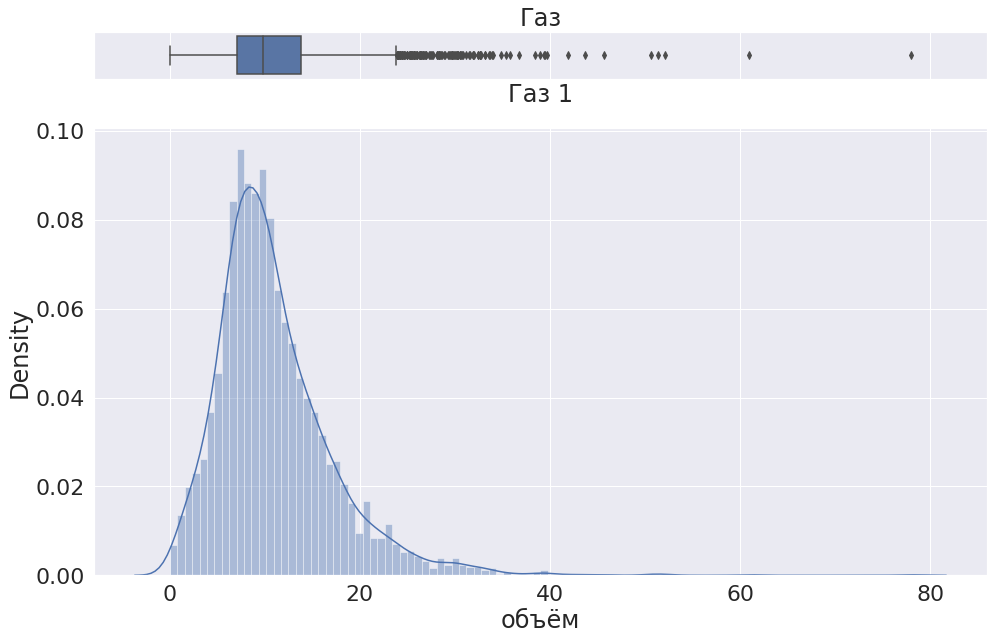

In [25]:
histogram_boxplot(data_gas['Газ 1'], bins = 100, title="Газ", xlabel="объём")

#### 1.5 Результаты измерения температуры

In [26]:
data_temp.head()

key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0

In [27]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [28]:
len(data_temp['key'].unique())

3216

<AxesSubplot:>

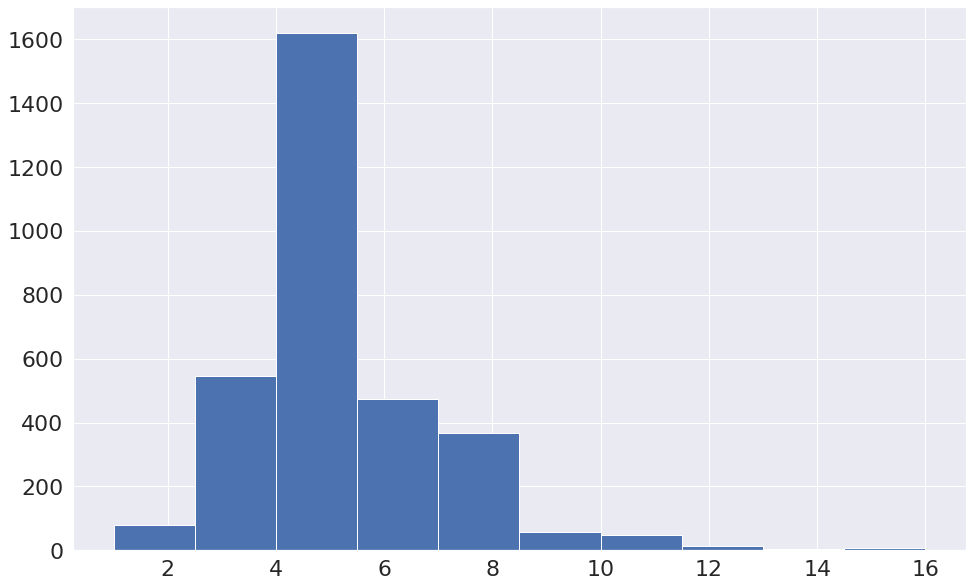

In [29]:
data_temp['key'].value_counts().hist(figsize=(16,10))

In [30]:
v = data_temp['key'].value_counts().reset_index()

In [31]:
v[v['key']==2]

index  key
3136   2862    2
3137      5    2
3138   1211    2
3139   2940    2
3140   1713    2
...     ...  ...
3209   2220    2
3210   2620    2
3211   1415    2
3212   1836    2
3213   2456    2

[78 rows x 2 columns]

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

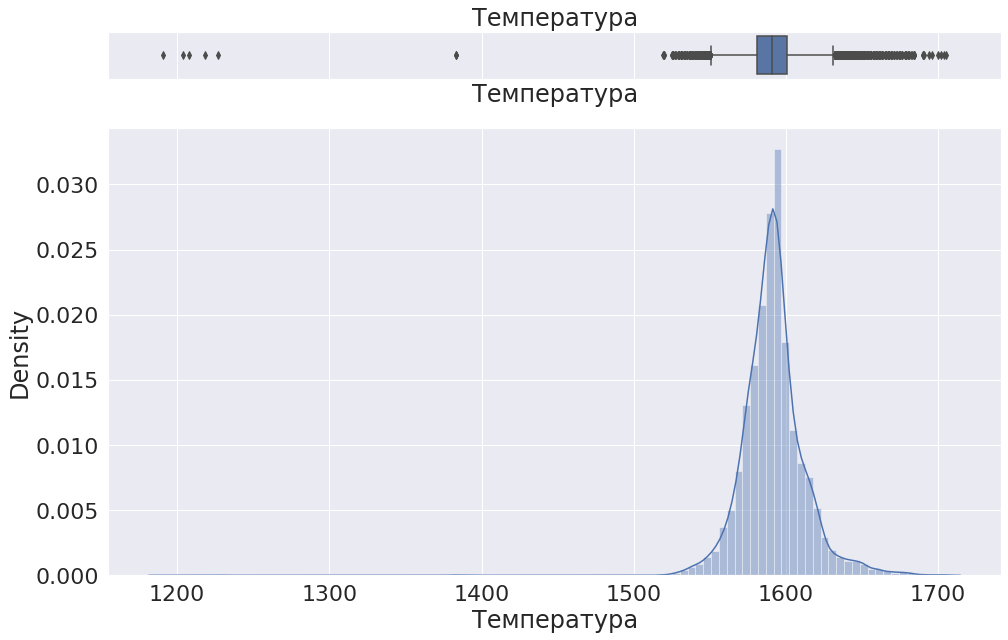

In [32]:
display(data_temp['Температура'].describe())
#data_temp['Температура'].hist(bins=100, figsize=(16,10))
histogram_boxplot(data_temp['Температура'], bins = 100, title="Температура", xlabel="Температура")

#### 1.6 Данные о проволочных материалах (объём)

In [33]:
data_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [34]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [35]:
fig = go.Figure()
for column in data_wire.columns:
    if column[0] == 'W':  
        fig.add_trace(go.Histogram(x=data_wire[column],name=column))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [36]:
data_wire.describe()

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

#### 1.7 Данные о проволочных материалах (время)

In [37]:
data_wire_time.head()

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

In [38]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [39]:

len(data_wire_time['key'].unique())

3081

#### Вывод:

Были онаружены следующие аномалии:
- в data_arc обнаружены отрицательные значения реактивной мощности. Стоит избавиться от данных аномалий. Требуется первести в формат datetime столбцы с датами. В данном датасете информация логирования технологического процесса нагрева электродов по каждой партии. Поэтому данные стоит сагрегировать по каждой партии в одну строку. Стоит избавиться от выбросов в агрегированных данных по активной и реактивной мощности.
- в data_bulk есть пропущенные значения. Скорее всего это значит что материал не добавлялся при плавке и можно их заменить на 0. Также формат данных в датасете используется не целочисленный, хотя все данные по объемам добавленного материала записал в целых числах, поэтому стоит изменить тип данных.
- в data_bulk_time прописано время добавление материала для каждой партии. Для обучения нашей модели информация о времени или последовательности добавления материала в партию будет избыточно. Единственное что можно проверить это попадают ли временные отметки добавление материала в диапазон времени нагрева электродами. Если будут аномалии то на них стоит обратить вниание и удалить эти партии из нашего анализа.
- в data_wire_time аналогичная ситуация что и с data_bulk_time стоит найти партии где подбрасывали легирующие компоненты после нагрева и удалить их.
- в  data_temp представлены записи замеров температуры при плавке стали. Есть данные когда нет последнего измерения температуры (то есть последнее измерение происходило еще до того как перестал работать электрод). Поэтому, по фатку эти партии без целевого показателя для обучения нашей модели и от них стоит избавиться.

В целом данные требуют предобработки от аномалий и группировкит по признаку key. Данные по температуре, газу, активной и реактивной мощности распределны нормально, но с небольшим количетсовм аномалий в данных.

### Предобработка данных

Обработка данных data_temp

избавление от аномалий в столбце Реактивная мощность

In [40]:
data_arc = data_arc[data_arc['Реактивная мощность']>0]

Расчет суммарной активной и реактивной мощности на каждую партию

In [41]:
data_arc_gr_s = pd.pivot_table(data_arc,
                             values=['Активная мощность','Реактивная мощность'],
                             index='key',
                             aggfunc={'Активная мощность': 'sum',
                                      'Реактивная мощность': 'sum'})



In [42]:
data_arc_gr_s.sample(5)

Активная мощность  Реактивная мощность
key                                         
870            2.399797             1.817904
2486           1.313285             1.163377
1172           2.622784             1.755190
2500           3.878814             2.943440
1297           1.803904             1.197129

In [43]:
data_arc[data_arc['key']==5]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
18    5  2019-05-03 13:11:13  2019-05-03 13:15:24           0.950026   
19    5  2019-05-03 13:18:21  2019-05-03 13:20:33           0.508026   
20    5  2019-05-03 13:23:32  2019-05-03 13:30:27           1.621665   
21    5  2019-05-03 13:32:44  2019-05-03 13:33:55           0.267457   

    Реактивная мощность  
18             0.690523  
19             0.332352  
20             1.047776  
21             0.181992

In [44]:
data_temp[data_temp['key']==5]

key         Время замера  Температура
19    5  2019-05-03 13:23:19       1576.0
20    5  2019-05-03 13:36:01       1602.0

In [45]:
data_wire_time[data_wire_time['key']==5]

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
4    NaN    NaN    NaN

Подготовка данных data_bulk_time и data_wire_time

In [46]:
data_bulk_time_t = pd.melt(data_bulk_time, id_vars=['key'], value_vars=['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'])
data_bulk_time_t.columns=['key','type_bulk','datetime']
data_bulk_time_t = data_bulk_time_t.dropna()

In [47]:
data_bulk_time_t.sample(5)

key type_bulk             datetime
29531  1423   Bulk 10  2019-06-23 14:06:20
43861    64   Bulk 15  2019-05-05 16:41:19
43665  3097   Bulk 14  2019-08-27 12:18:19
46881  3185   Bulk 15  2019-08-30 09:09:56
46498  2793   Bulk 15  2019-08-16 19:38:51

In [48]:
data_wire_time_t = pd.melt(data_wire_time, id_vars=['key'], value_vars=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'])
data_wire_time_t.columns=['key','type_wire','datetime']
data_wire_time_t = data_wire_time_t.dropna()
#data_wire_time_gr = data_wire_time_t.groupby(['key','type_wire'])['datetime'].count().reset_index()

In [49]:
data_wire_time_t.sample(5)

key type_wire             datetime
2209  2320    Wire 1  2019-07-30 16:29:54
2885  3044    Wire 1  2019-08-25 19:14:12
4021  1000    Wire 2  2019-06-09 01:08:39
304    327    Wire 1  2019-05-15 15:00:00
3575   527    Wire 2  2019-05-22 21:10:00

Поиск и удаление партий где последний замер температуры был раньше прекращения нагрева метала, где начальная и конечная измеренная температура сплава равны друг другу и где добавление сыпучего или проволочного материала происходило уже после нагрева электродами.

In [50]:
issue = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['Время замера'].max() < 
            data_arc[data_arc['key'] == key]['Конец нагрева дугой'].max()) or
           (data_temp[data_temp['key'] == key]['Время замера'].max() == 
            data_temp[data_temp['key'] == key]['Время замера'].min()) or 
           (data_bulk_time_t[data_bulk_time_t['key'] == key]['datetime'].max() > 
            data_arc[data_arc['key'] == key]['Конец нагрева дугой'].max()) or
           (data_wire_time_t[data_wire_time_t['key'] == key]['datetime'].max() > 
            data_arc[data_arc['key'] == key]['Конец нагрева дугой'].max())):
            issue.append(key)
    except:
        issue.append(key)

In [51]:
data_temp[data_temp['key'] == 1]['Время замера'].max()

'2019-05-03 11:30:39'

In [52]:
data_temp[data_temp['key'] == 1]

key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0

In [53]:
print('Кол-во аномальных партий', len(issue))

Кол-во аномальных партий 557


Очистка data_temp от аномальных партий и пропущенных значений

In [54]:
data_temp = data_temp[~data_temp['key'].isin(issue)]

In [55]:
data_temp = data_temp.dropna()

In [56]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10939 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           10939 non-null  int64  
 1   Время замера  10939 non-null  object 
 2   Температура   10939 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 341.8+ KB


Поиск и очистка от партий, где было меньше 2-х замеров температуры

In [57]:
a = data_temp['key'].value_counts().reset_index()

In [58]:
keys_less_two_measuring = a[a['key']<2]['index'].values
data_temp = data_temp[~data_temp['key'].isin(keys_less_two_measuring )]

установление форматы date у столбца Время замера

In [59]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

Нахождение max и min температуры для каждой партии

In [60]:
data_temp.columns = ['key', 'time','temp']
pt_data_temp = pd.pivot_table(data_temp,
                                values='time',
                                index='key',
                                aggfunc={'time': [np.min, np.max]})
pt_data_temp

amax                amin
key                                         
1    2019-05-03 11:30:39 2019-05-03 11:16:18
2    2019-05-03 11:59:12 2019-05-03 11:37:27
3    2019-05-03 12:34:57 2019-05-03 12:13:17
4    2019-05-03 12:59:25 2019-05-03 12:52:57
5    2019-05-03 13:36:01 2019-05-03 13:23:19
...                  ...                 ...
2495 2019-08-06 00:54:42 2019-08-06 00:35:45
2496 2019-08-06 01:29:52 2019-08-06 01:02:54
2497 2019-08-06 01:53:50 2019-08-06 01:41:53
2498 2019-08-06 02:25:31 2019-08-06 02:03:49
2499 2019-08-06 03:00:28 2019-08-06 02:40:25

[2050 rows x 2 columns]

In [61]:
pt_data_temp = pt_data_temp.reset_index()
pt_data_temp = pt_data_temp.merge(data_temp , left_on=['key','amax'], right_on=['key','time'])
pt_data_temp.columns = ['key', 'amax', 'amin', 'time', 'end_temp']
pt_data_temp = pt_data_temp.merge(data_temp , left_on=['key','amin'], right_on=['key','time'])
pt_data_temp.columns = ['key', 'amax', 'amin', 'time_x', 'end_temp','time_y','start_temp']
data_temp_final = pt_data_temp[['key','start_temp','end_temp']]
data_temp_final = data_temp_final.set_index('key')

In [62]:
data_temp_final 

start_temp  end_temp
key                       
1         1571.0    1613.0
2         1581.0    1602.0
3         1596.0    1599.0
4         1601.0    1625.0
5         1576.0    1602.0
...          ...       ...
2495      1570.0    1591.0
2496      1554.0    1591.0
2497      1571.0    1589.0
2498      1591.0    1594.0
2499      1569.0    1603.0

[2050 rows x 2 columns]

Подготовка всех датасетов к объединению

In [63]:
data_bulk = data_bulk.set_index('key')
data_gas = data_gas.set_index('key')
data_gas.columns = ['gas']
data_wire = data_wire.set_index('key')


Объединение всех датасетов

In [64]:
data = data_temp_final.join(data_arc_gr_s)
data = data.join(data_bulk)
data = data.join(data_gas)
data = data.join(data_wire)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2050 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   start_temp           2050 non-null   float64
 1   end_temp             2050 non-null   float64
 2   Активная мощность    2050 non-null   float64
 3   Реактивная мощность  2050 non-null   float64
 4   Bulk 1               175 non-null    float64
 5   Bulk 2               11 non-null     float64
 6   Bulk 3               854 non-null    float64
 7   Bulk 4               704 non-null    float64
 8   Bulk 5               50 non-null     float64
 9   Bulk 6               398 non-null    float64
 10  Bulk 7               11 non-null     float64
 11  Bulk 8               1 non-null      float64
 12  Bulk 9               13 non-null     float64
 13  Bulk 10              118 non-null    float64
 14  Bulk 11              113 non-null    float64
 15  Bulk 12              1642 non-null   f

столбец Wire 5 не имеет значений, поэтому изабвимся от него

In [66]:
data = data.drop('Wire 5',axis=1)

Приведем столбцы к нужным типам данным а Nan заполним нулями

In [67]:
data = data.fillna(0)
data['start_temp'] = pd.to_numeric(data['start_temp'], downcast='integer')
data['end_temp'] = pd.to_numeric(data['end_temp'], downcast='integer')
for i in range(1,16):
    data[f'Bulk {i}'] = pd.to_numeric(data[f'Bulk {i}'], downcast='integer')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2050 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   start_temp           2050 non-null   int16  
 1   end_temp             2050 non-null   int16  
 2   Активная мощность    2050 non-null   float64
 3   Реактивная мощность  2050 non-null   float64
 4   Bulk 1               2050 non-null   int16  
 5   Bulk 2               2050 non-null   int16  
 6   Bulk 3               2050 non-null   int16  
 7   Bulk 4               2050 non-null   int16  
 8   Bulk 5               2050 non-null   int16  
 9   Bulk 6               2050 non-null   int16  
 10  Bulk 7               2050 non-null   int16  
 11  Bulk 8               2050 non-null   int8   
 12  Bulk 9               2050 non-null   int16  
 13  Bulk 10              2050 non-null   int16  
 14  Bulk 11              2050 non-null   int16  
 15  Bulk 12              2050 non-null   i

по heatmap посмотрим сильно коррелирующие фичи и избавимся от одной из каждой таких пар.

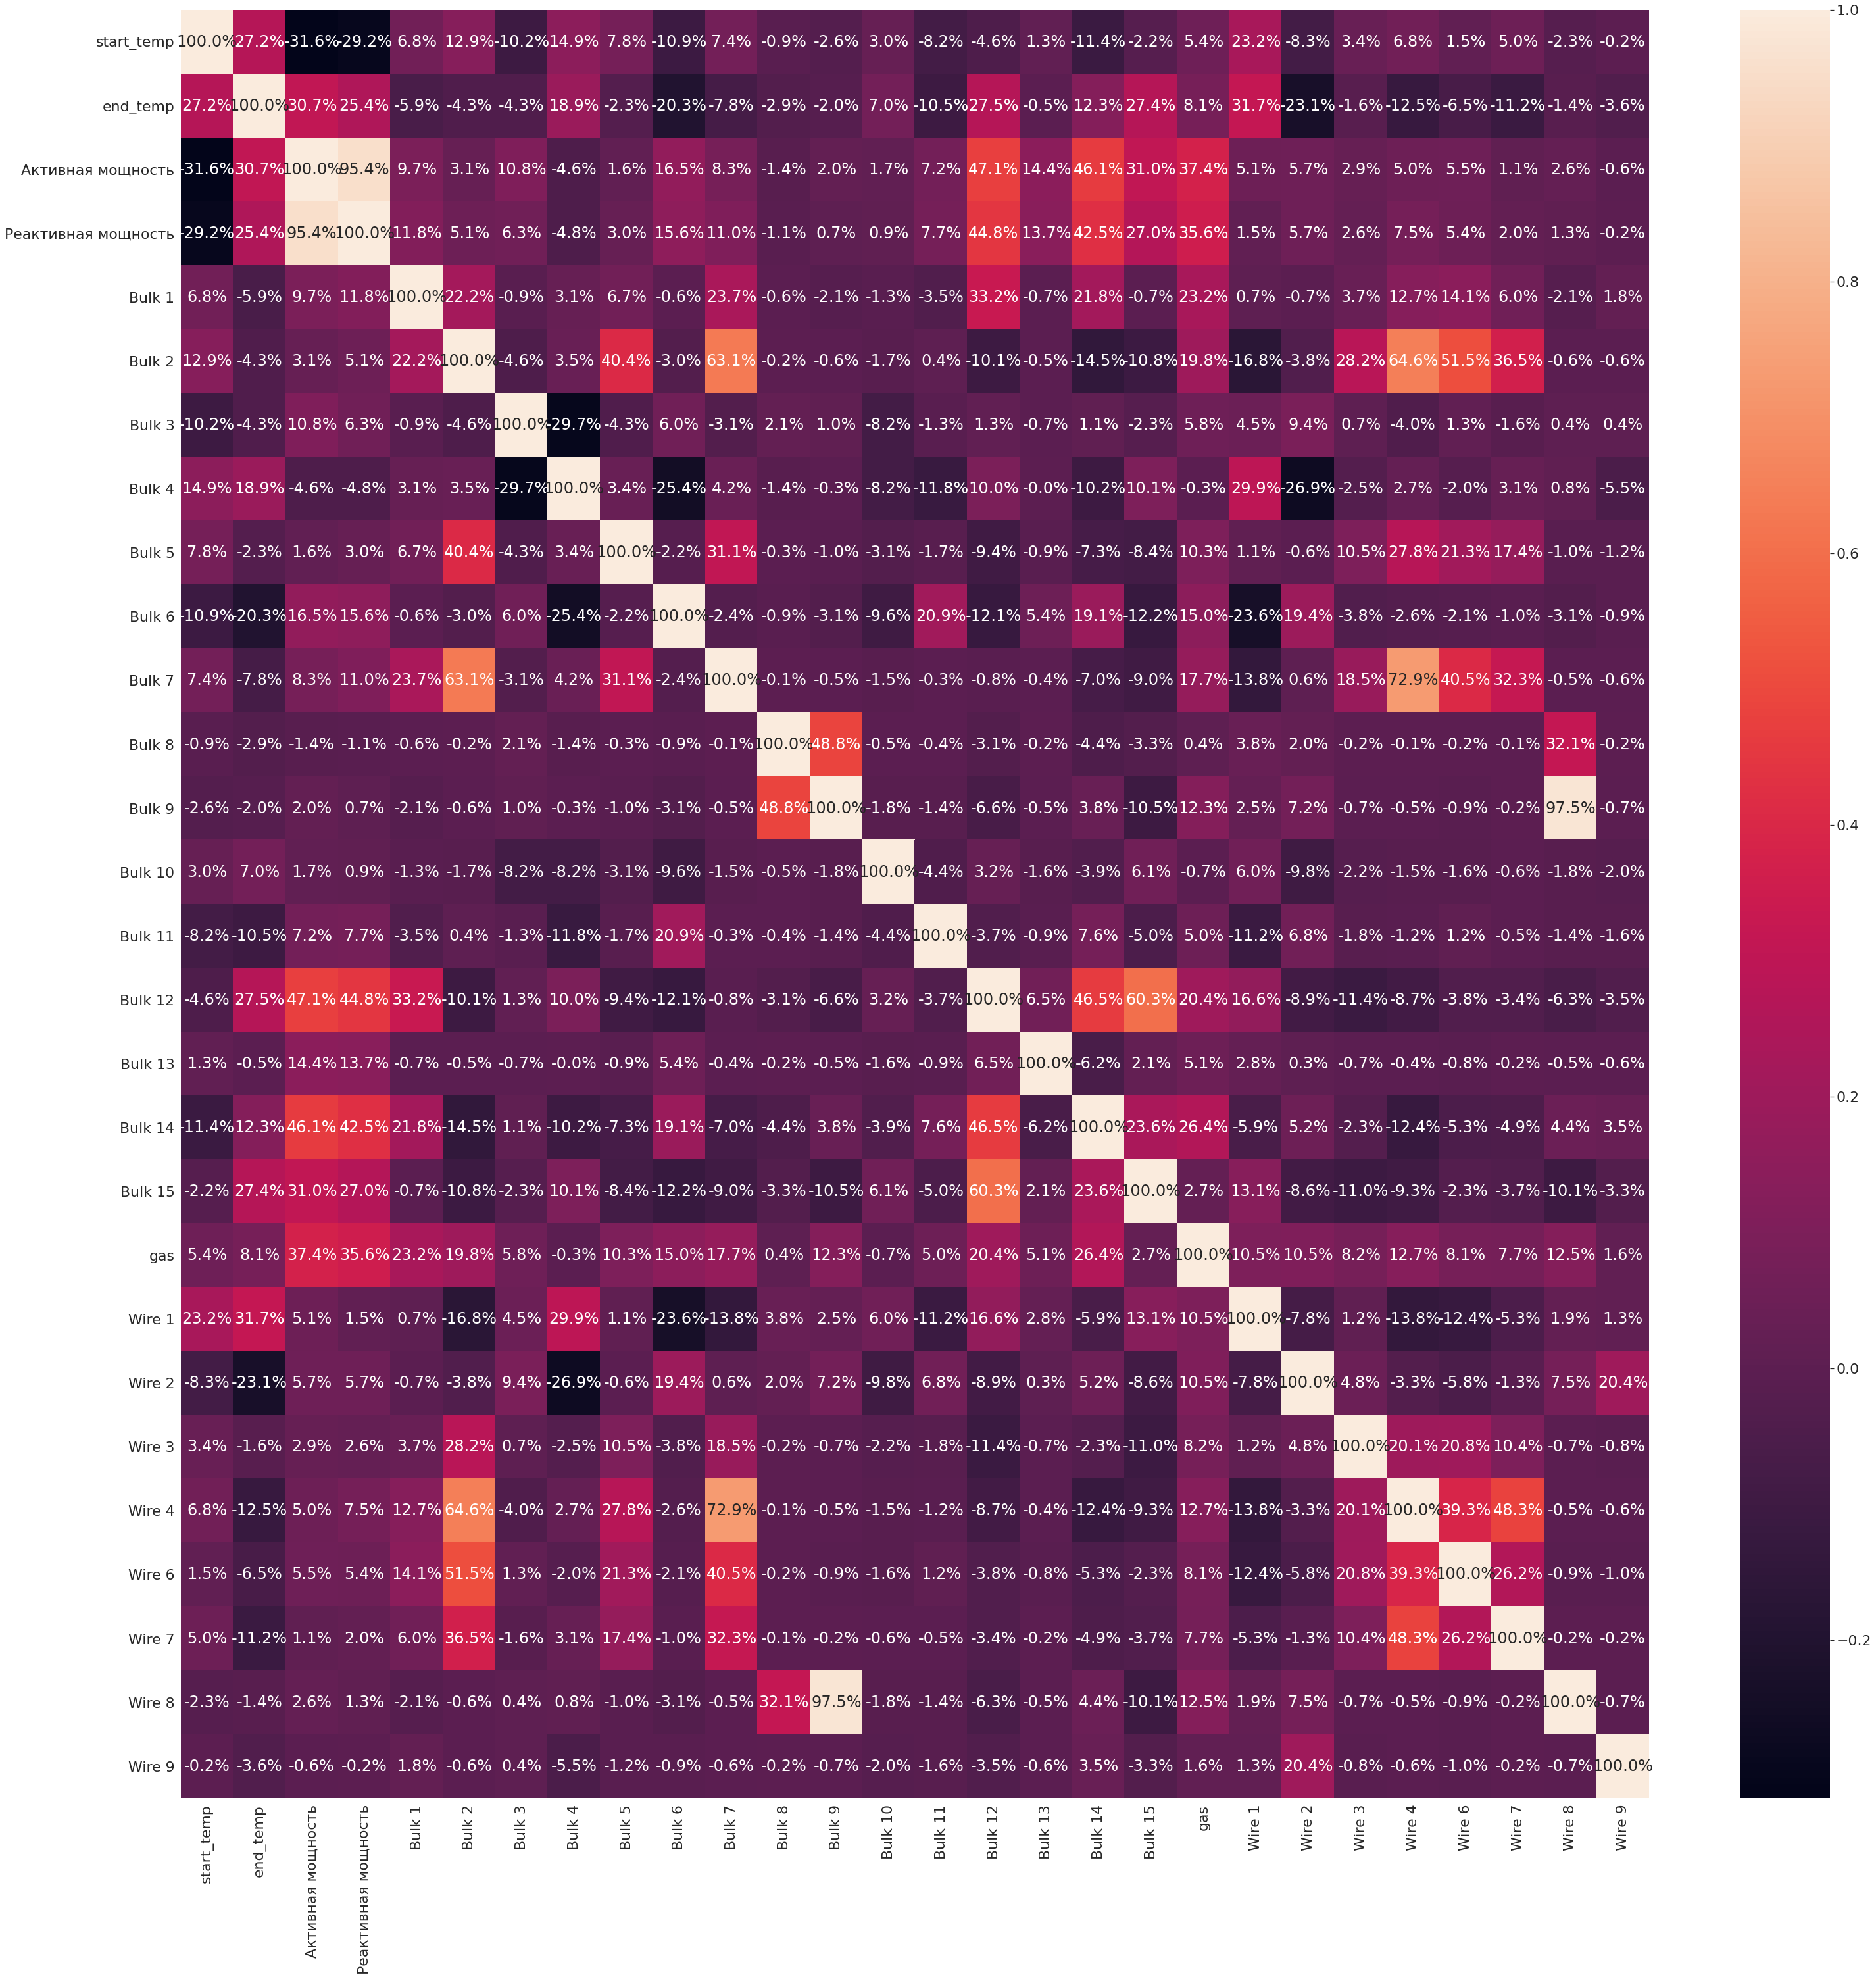

In [68]:
corr = data.corr()
plt.figure(figsize=(50,50))
sns.heatmap(corr, annot=True,fmt=".1%")
plt.show()

Под данные критерии попали столбцы Wire 8 и Реактивная мощность

In [69]:
data = data.drop(['Реактивная мощность', 'Wire 8'], axis=1)

In [70]:
len(data)

2050

Поиск аномалий по столбцам с наиболее коррелирующими с целевой переменной 

In [71]:
data.corr()['end_temp'].abs() >= 0.3

start_temp           False
end_temp              True
Активная мощность     True
Bulk 1               False
Bulk 2               False
Bulk 3               False
Bulk 4               False
Bulk 5               False
Bulk 6               False
Bulk 7               False
Bulk 8               False
Bulk 9               False
Bulk 10              False
Bulk 11              False
Bulk 12              False
Bulk 13              False
Bulk 14              False
Bulk 15              False
gas                  False
Wire 1                True
Wire 2               False
Wire 3               False
Wire 4               False
Wire 6               False
Wire 7               False
Wire 9               False
Name: end_temp, dtype: bool

In [72]:
clf = IsolationForest( max_samples=100, random_state = 12345)
preds = clf.fit_predict(data[['end_temp','Активная мощность','Wire 1']])
data['unnorm'] = preds
data_un = data[data['unnorm']==1]
print('Найдено аномали',len(data)-len(data_un))

Найдено аномали 564


In [73]:
data_un=data_un[data_un['start_temp']>1399]

In [74]:
data_un.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1483 entries, 2 to 2499
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   start_temp         1483 non-null   int16  
 1   end_temp           1483 non-null   int16  
 2   Активная мощность  1483 non-null   float64
 3   Bulk 1             1483 non-null   int16  
 4   Bulk 2             1483 non-null   int16  
 5   Bulk 3             1483 non-null   int16  
 6   Bulk 4             1483 non-null   int16  
 7   Bulk 5             1483 non-null   int16  
 8   Bulk 6             1483 non-null   int16  
 9   Bulk 7             1483 non-null   int16  
 10  Bulk 8             1483 non-null   int8   
 11  Bulk 9             1483 non-null   int16  
 12  Bulk 10            1483 non-null   int16  
 13  Bulk 11            1483 non-null   int16  
 14  Bulk 12            1483 non-null   int16  
 15  Bulk 13            1483 non-null   int16  
 16  Bulk 14            1483 

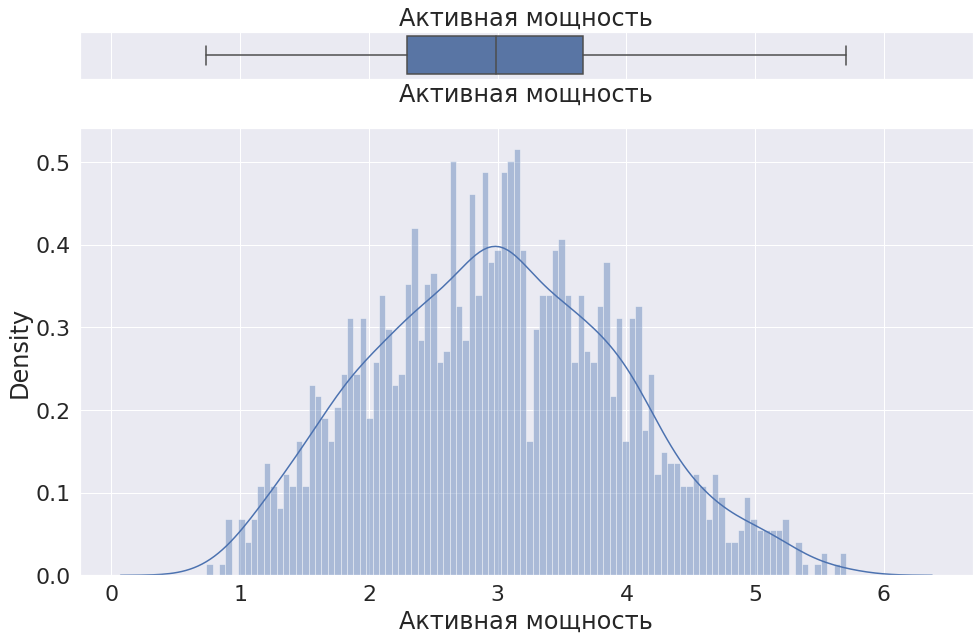

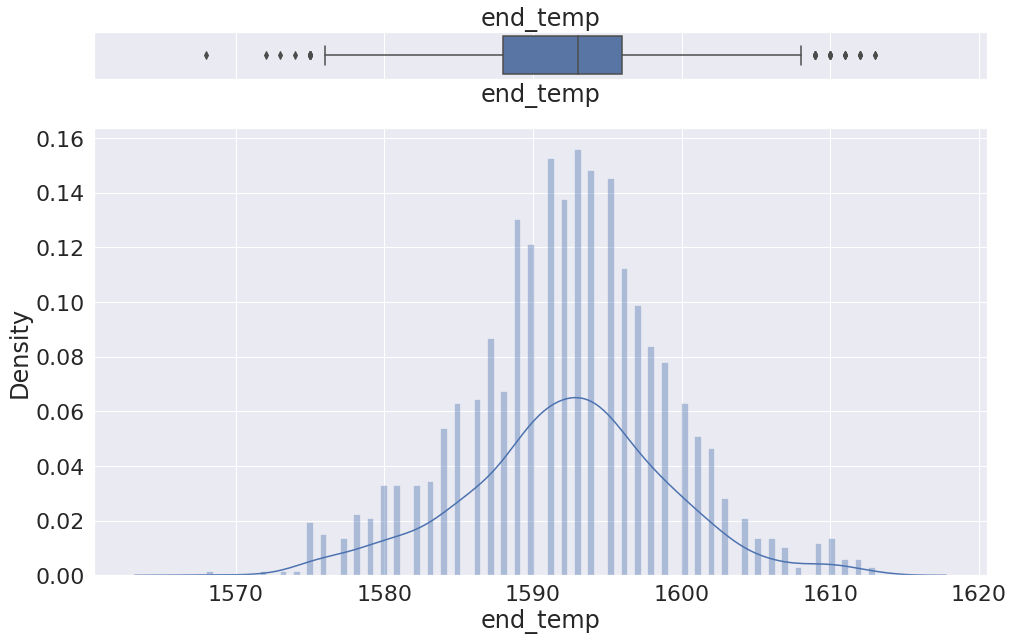

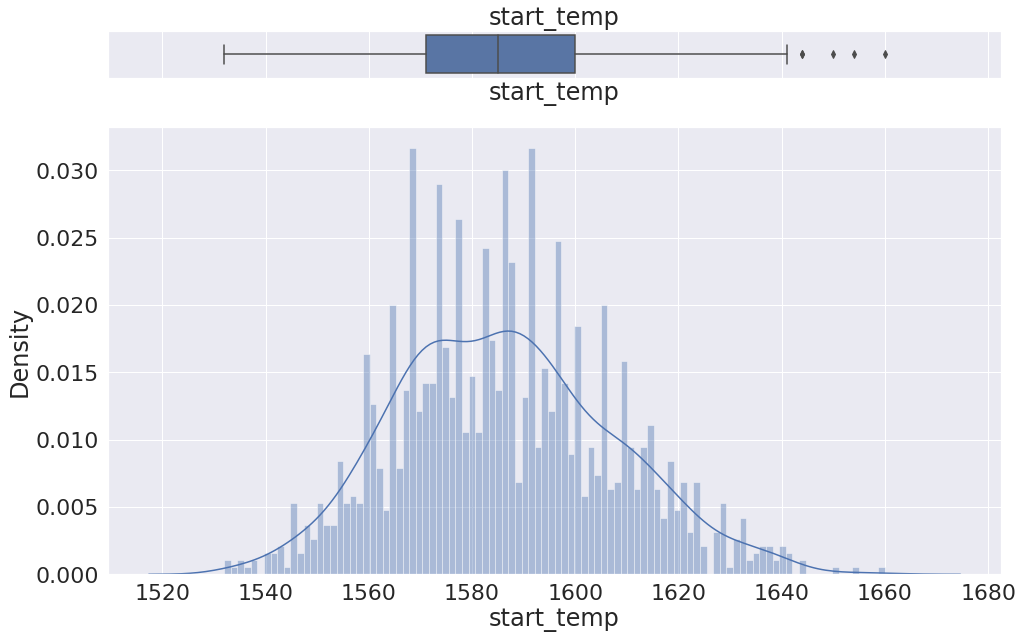

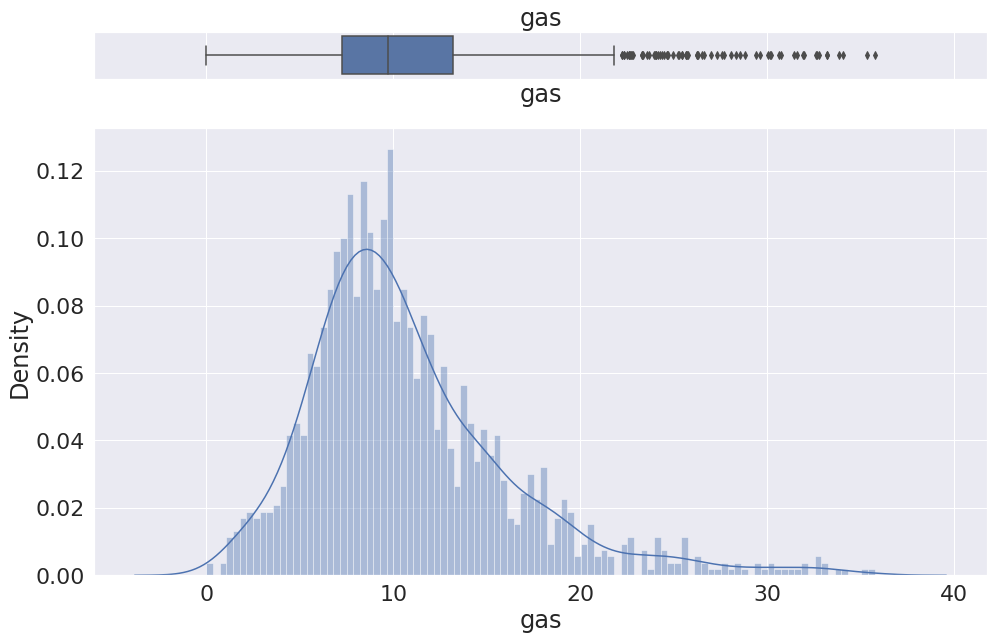

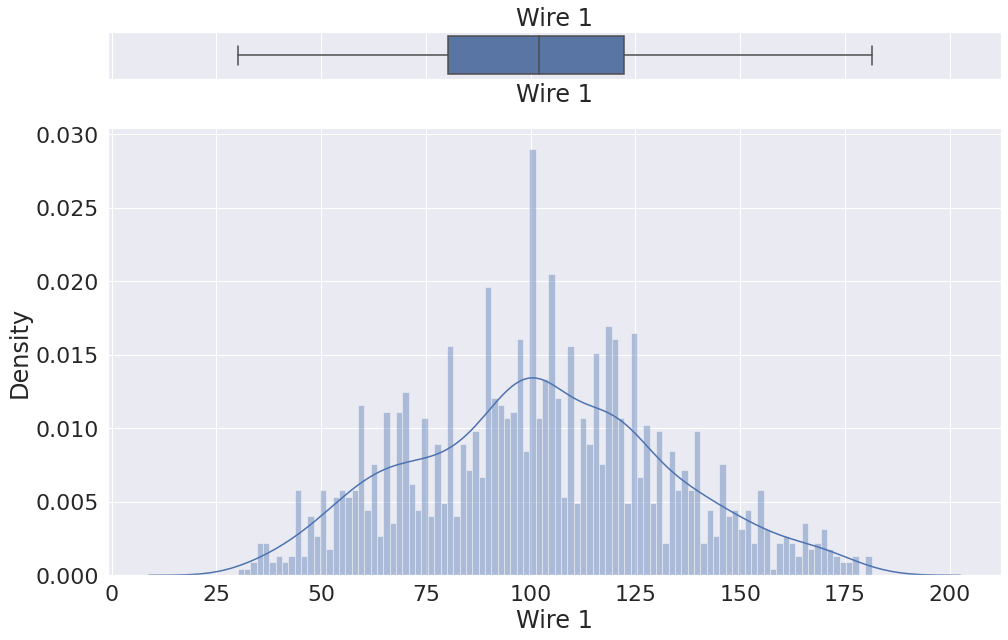

In [75]:
s=['Активная мощность','end_temp','start_temp','gas','Wire 1']
for i in s:
    histogram_boxplot(data_un[i], bins = 100, title=i, xlabel=i)

#### Вывод: 

Данные очищенны и подготовлены, целевым признаком является end_temp, остальные будут использоваться для построения модели

In [76]:
data_temp.describe()

key          temp
count  10330.000000  10330.000000
mean    1225.691772   1590.037464
std      722.939518     17.775731
min        1.000000   1191.000000
25%      602.000000   1580.000000
50%     1228.000000   1591.000000
75%     1852.000000   1599.000000
max     2499.000000   1662.000000

In [77]:
data_un.describe()

start_temp     end_temp  Активная мощность       Bulk 1  Bulk 2  \
count  1483.000000  1483.000000        1483.000000  1483.000000  1483.0   
mean   1586.335131  1592.250169           2.992043     3.070802     0.0   
std      20.997758     6.900497           0.955767    11.130970     0.0   
min    1532.000000  1568.000000           0.736672     0.000000     0.0   
25%    1571.000000  1588.000000           2.296394     0.000000     0.0   
50%    1585.000000  1593.000000           2.983930     0.000000     0.0   
75%    1600.000000  1596.000000           3.661698     0.000000     0.0   
max    1660.000000  1613.000000           5.709231    94.000000     0.0   

            Bulk 3       Bulk 4       Bulk 5       Bulk 6       Bulk 7  ...  \
count  1483.000000  1483.000000  1483.000000  1483.000000  1483.000000  ...   
mean     47.132165    39.365475     2.416723    17.822657     0.050573  ...   
std      73.567737    60.139839    19.658015    49.111666     1.947559  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%      79.500000    80.500000     0.000000     0.000000     0.000000  ...   
max     454.000000   281.000000   293.000000   407.000000    75.000000  ...   

           Bulk 15          gas       Wire 1       Wire 2       Wire 3  \
count  1483.000000  1483.000000  1483.000000  1483.000000  1483.000000   
mean    123.659474    10.797960   102.292521    16.033475     1.384385   
std      80.888074     5.500616    30.463349    31.083433    18.858434   
min       0.000000     0.000000    30.092400     0.000000     0.000000   
25%      99.500000     7.241475    80.182442     0.000000     0.000000   
50%     108.000000     9.712125   102.023994     0.000000     0.000000   
75%     204.000000    13.221845   122.218200    19.619079     0.000000   
max     290.000000    35.769306   181.350006   210.245362   285.116821   

       Wire 4       Wire 6  Wire 7       Wire 9  unnorm  
count  1483.0  1483.000000  1483.0  1483.000000  1483.0  
mean      0.0     0.526950     0.0     0.353519     1.0  
std       0.0     6.817320     0.0     3.682965     0.0  
min       0.0     0.000000     0.0     0.000000     1.0  
25%       0.0     0.000000     0.0     0.000000     1.0  
50%       0.0     0.000000     0.0     0.000000     1.0  
75%       0.0     0.000000     0.0     0.000000     1.0  
max       0.0   180.454575     0.0    62.025600     1.0  

[8 rows x 27 columns]

### 3 Обучение модели

разбиение данных на train и test c кросс-валидацией = 5

In [78]:
random_state = 12345
features = data_un.drop('end_temp', axis=1)
target = data_un['end_temp']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=random_state)
cv_counts = 5

#### Поиск лучших фитч для обучения с помощью CatBoostRegressor

In [79]:
model = CatBoostRegressor(verbose=False, random_state=random_state)
model.fit(features_train, target_train)


Создание df с оценкой важности фитч

In [80]:
f_i = pd.DataFrame({'feature_importance': model.get_feature_importance(Pool(features_train, target_train)), 
              'feature_names': features.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

Функция построения графика с оценкой важности фитс

In [81]:
def plot_feature_importance(importance,names,model_type):
    
    #создание массива важности фитч и их названий
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #создание датафрейма
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #сортировка по важности фитч
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #построение графика
    plt.figure(figsize=(10,8))
 
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + 'feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('feature names')

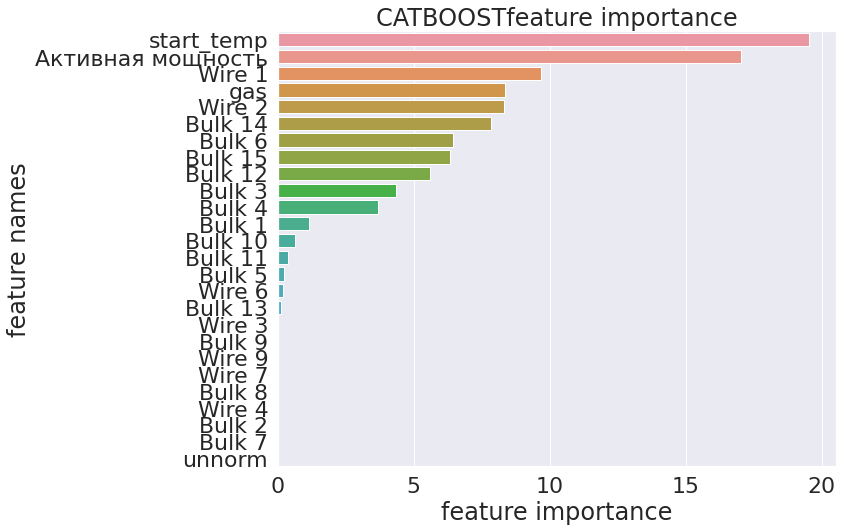

In [82]:
plot_feature_importance(model.get_feature_importance(),features_train.columns,'CATBOOST')

топ 11 важных фитч для обучения моделей

In [83]:
f_i.head(11)['feature_names'].values

array(['start_temp', 'Активная мощность', 'Wire 1', 'gas', 'Wire 2',
       'Bulk 14', 'Bulk 6', 'Bulk 15', 'Bulk 12', 'Bulk 3', 'Bulk 4'],
      dtype=object)

In [84]:
features = data_un[f_i.head(11)['feature_names'].values]

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=random_state)

#### 3.1 CatBoostRegressor

In [85]:
%%time
model = CatBoostRegressor(verbose=False, random_state=random_state)
print('Идет обучение модели...')
print()
mae_cat = (cross_val_score(model, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean()*(-1))
print('Mean MAE on CatBoostRegressor =', mae_cat)


Идет обучение модели...

Mean MAE on CatBoostRegressor = 4.422942656377092
CPU times: user 8.71 s, sys: 220 ms, total: 8.93 s
Wall time: 11.4 s


#### 3.2 LinearRegression

In [86]:
%%time

model = LinearRegression()
print('Идет обучение модели...')
print()
mae_lr = (cross_val_score(model, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE on LinearRegression =', mae_lr)

Идет обучение модели...

Mean MAE on LinearRegression = 4.403701726533017
CPU times: user 41.6 ms, sys: 20.6 ms, total: 62.2 ms
Wall time: 23.2 ms


#### 3.3 RandomForestRegressor

In [87]:
model = RandomForestRegressor() 
param = [{'criterion':['mse'],
                'n_estimators':[x for x in range(500, 1000, 50)], 
                'random_state':[random_state]}]

print('Поиск лучших параметров...')
print()
clf = GridSearchCV(model, param, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Лучшие параметры RandomForestRegressor:")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)

Поиск лучших параметров...

Лучшие параметры RandomForestRegressor:

{'criterion': 'mse', 'n_estimators': 900, 'random_state': 12345}


In [88]:
%%time

model = RandomForestRegressor()
model.set_params(**best_params_RFR)
mae_rfr = (cross_val_score(model, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean()*(-1))
print('Mean MAE on RandomForestRegressor =', mae_rfr)

Mean MAE on RandomForestRegressor = 4.355240173004669
CPU times: user 19.4 s, sys: 67.7 ms, total: 19.5 s
Wall time: 19.5 s


#### 3.4 Проверка моделей на тестовой выборке

In [89]:
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(features_train, 
                                        target_train).get_all_params()
best_params_CBR

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 12345,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04118499904870987,
 'score_function': 'Cosine',
 'task_t

CatBoostRegressor

In [90]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_mae_cat = mean_absolute_error(target_predict, target_test)
print('MAE on test of CatBoostRegressor =', test_mae_cat)

MAE on test of CatBoostRegressor = 4.542764460778725
CPU times: user 1.86 s, sys: 36.2 ms, total: 1.89 s
Wall time: 2.38 s


 RandomForestRegressor

In [91]:
%%time

model = RandomForestRegressor()
model.set_params(**best_params_RFR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_mae_rfr = mean_absolute_error(target_predict, target_test)
print('MAE on test of RandomForestRegressor =', test_mae_rfr)

MAE on test of RandomForestRegressor = 4.5926042446941295
CPU times: user 4.77 s, sys: 12 ms, total: 4.78 s
Wall time: 4.78 s


LinearRegression

In [92]:

%%time

model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_mae_lr = mean_absolute_error(target_predict, target_test)
print('MAE on test for LinearRegression =', test_mae_lr)

MAE on test for LinearRegression = 4.693909725262158
CPU times: user 3.74 ms, sys: 7.98 ms, total: 11.7 ms
Wall time: 5.84 ms


In [93]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor']
data_res = {'mae CV':[mae_lr,
                     mae_rfr,
                     mae_cat],
        'mae test':[test_mae_lr,
                     test_mae_rfr,
                     test_mae_cat]}

In [94]:
results = pd.DataFrame(data=data_res, index=index)

In [95]:
results

mae CV  mae test
LinearRegression       4.403702  4.693910
RandomForestRegressor  4.355240  4.592604
CatBoostRegressor      4.422943  4.542764

#### Вывод: 

на тестовых выборках все модели показали хорошие результаты. Лучший mae 4.56 был получем при использовании модели расчитанной на CatBoostRegressor. Однако, учитывая наш целевой показатель mae<6, то рабочей моделью можно выбрать LinearRegression, так как она легче всего интерпретируема.